<a href="https://colab.research.google.com/github/kanishkautag/Paper-Implementations/blob/main/Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
%pip install -q diffusers

In [4]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 337kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.13MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.62MB/s]


In [5]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

torch.Size([8, 1, 28, 28])
tensor([1, 4, 3, 5, 5, 7, 3, 0])


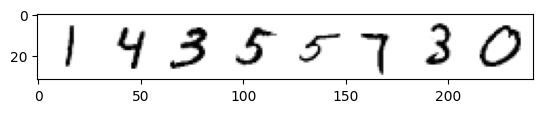

In [27]:
x,y=next(iter(train_dataloader))
print(x.shape)
print(y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

Corruption/Noise

In [29]:
def corrupt(x,amount):
  noise=torch.rand_like(x)
  amount=amount.view(-1,1,1,1)
  return x*(1-amount)+noise*amount

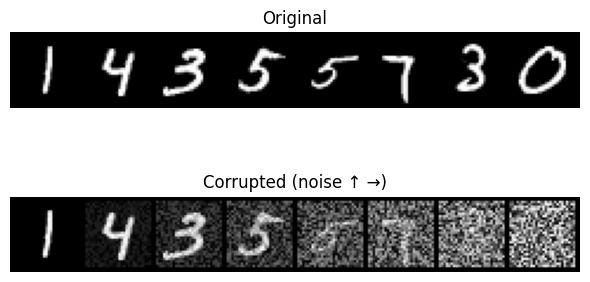

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(6, 4))

# Top: original
grid_orig = torchvision.utils.make_grid(x, nrow=x.shape[0])  # → [3, H', W']
# Permute to H'×W'×3 for RGB
axs[0].imshow(grid_orig.permute(1,2,0).cpu().numpy())
axs[0].set_title('Original')
axs[0].axis('off')

# Bottom: corrupted
amount = torch.linspace(0, 1, steps=x.shape[0])
noised = corrupt(x, amount)
grid_noised = torchvision.utils.make_grid(noised, nrow=x.shape[0])
axs[1].imshow(grid_noised.permute(1,2,0).cpu().numpy())
axs[1].set_title('Corrupted (noise ↑ →)')
axs[1].axis('off')

plt.tight_layout()
plt.show()

x is a 4D tensor (like a batch of images).

amount is reshaped to match the batch size for broadcasting.

torch.rand_like(x) generates noise with the same shape as x.

In [18]:
x = torch.ones((2, 3, 4, 4))  #
amount = torch.tensor([0.3, 0.7])

print(corrupt(x, amount))

tensor([[[[0.9333, 0.7801, 0.7007, 0.8296],
          [0.7839, 0.8190, 0.8968, 0.9493],
          [0.9922, 0.8579, 0.7329, 0.7207],
          [0.7065, 0.9352, 0.9017, 0.9146]],

         [[0.8771, 0.8412, 0.7913, 0.7932],
          [0.7574, 0.9867, 0.8036, 0.9232],
          [0.8852, 0.7888, 0.9704, 0.8348],
          [0.7876, 0.9289, 0.8947, 0.8603]],

         [[0.7369, 0.8910, 0.9608, 0.8518],
          [0.7555, 0.9278, 0.8937, 0.7665],
          [0.8697, 0.7815, 0.8545, 0.9719],
          [0.8829, 0.9267, 0.9525, 0.9031]]],


        [[[0.5741, 0.7055, 0.4986, 0.7719],
          [0.8380, 0.6313, 0.9470, 0.7138],
          [0.8325, 0.9113, 0.5085, 0.6523],
          [0.7065, 0.8157, 0.8062, 0.8765]],

         [[0.4637, 0.5426, 0.6359, 0.4543],
          [0.5249, 0.9147, 0.5168, 0.8031],
          [0.8552, 0.7589, 0.3164, 0.7959],
          [0.3025, 0.7313, 0.4342, 0.3881]],

         [[0.4114, 0.7794, 0.9697, 0.8794],
          [0.9310, 0.8750, 0.5241, 0.4961],
          [0.5046, 0

In [31]:
#UNET CODE IDK
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

In [32]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

Finished epoch 0. Average loss for this epoch: 0.026017


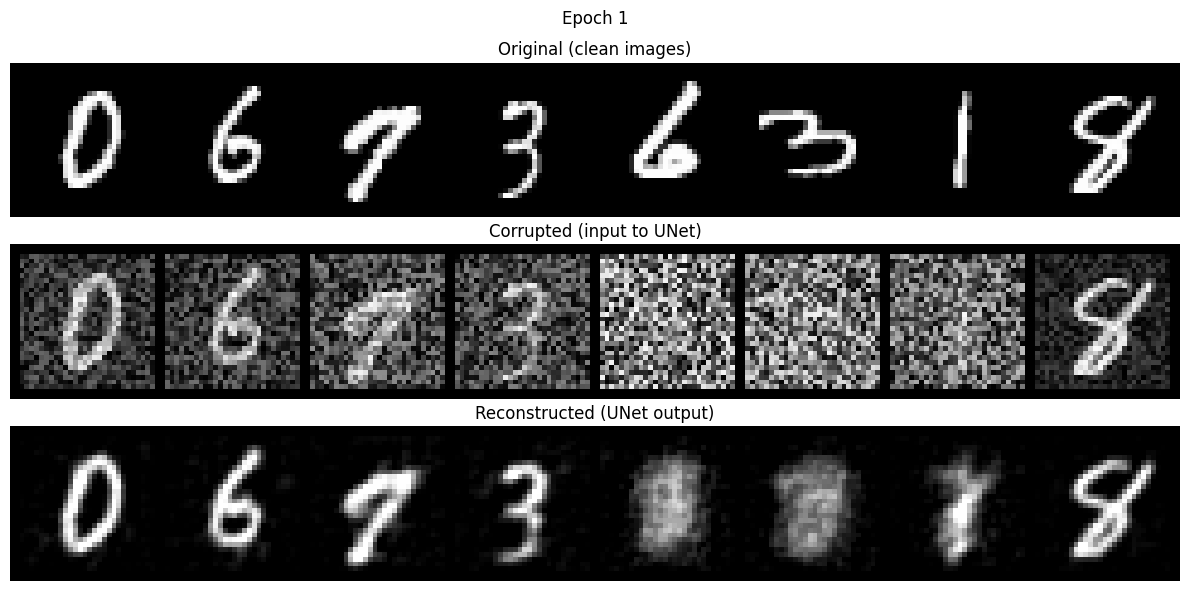

Finished epoch 1. Average loss for this epoch: 0.020072


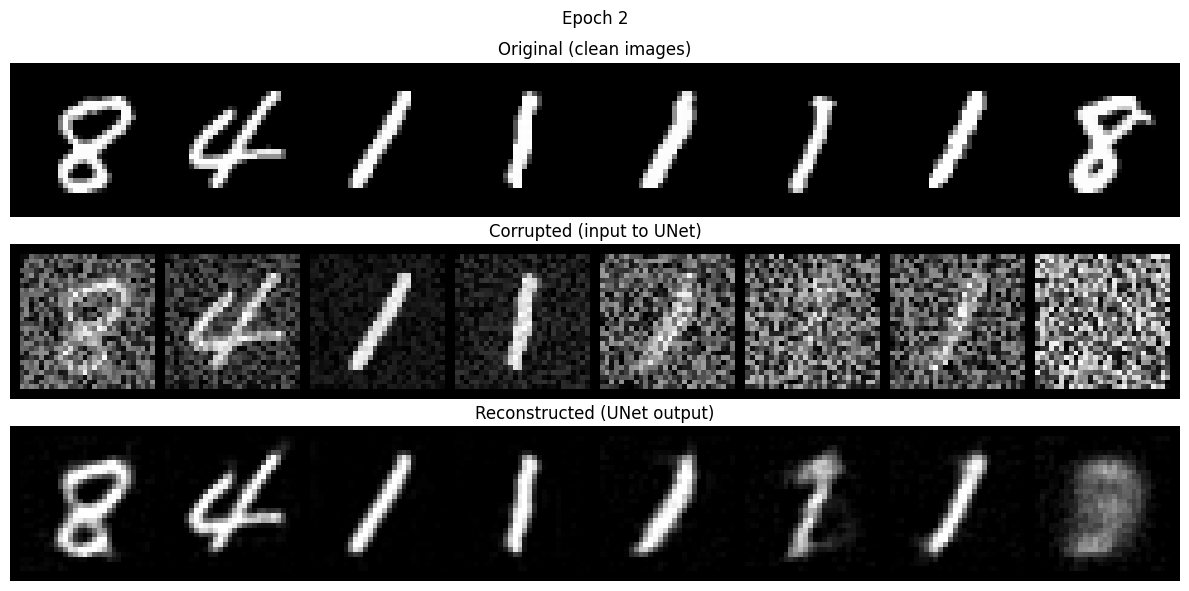

Finished epoch 2. Average loss for this epoch: 0.018244


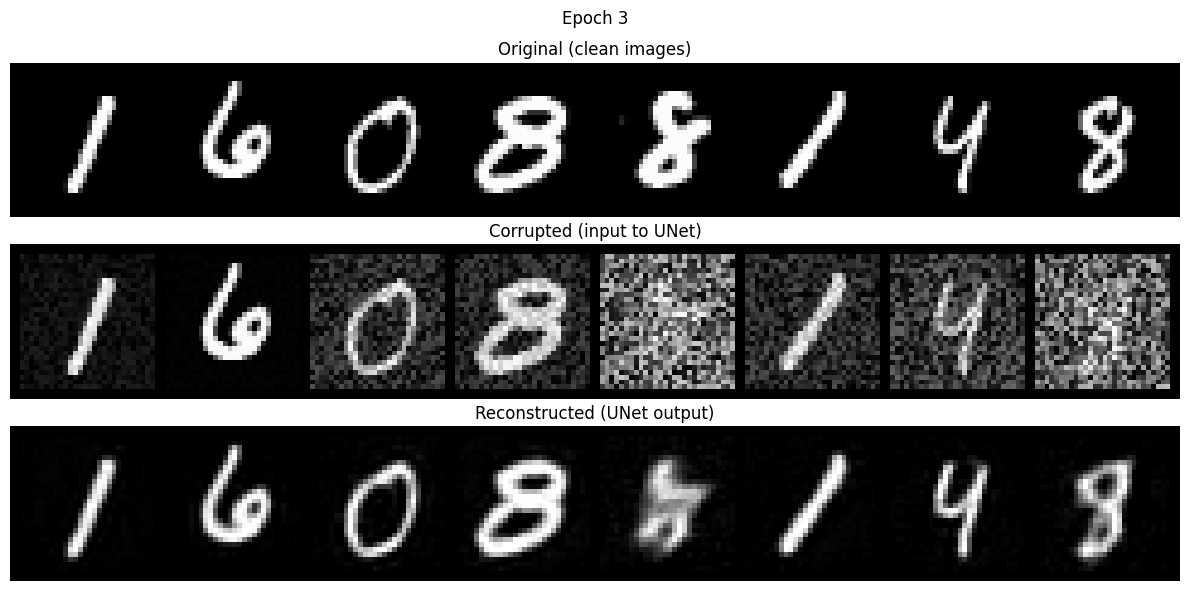

In [34]:
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x)

        loss = loss_fn(pred, x)
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    # === Visualize 8 samples from this batch ===
    sample_count = 8
    with torch.no_grad():
        x_sample = x[:sample_count].cpu()
        noisy_sample = noisy_x[:sample_count].cpu()
        pred_sample = pred[:sample_count].cpu()

        def show_image_row(tensor, title, row_idx):
            img_grid = torchvision.utils.make_grid(tensor, nrow=sample_count, padding=2)
            axs[row_idx].imshow(img_grid.permute(1, 2, 0).squeeze(), cmap='gray')
            axs[row_idx].set_title(title)
            axs[row_idx].axis('off')

        fig, axs = plt.subplots(3, 1, figsize=(12, 6))
        show_image_row(x_sample,        "Original (clean images)",        0)
        show_image_row(noisy_sample,    "Corrupted (input to UNet)",      1)
        show_image_row(pred_sample,     "Reconstructed (UNet output)",    2)
        plt.suptitle(f"Epoch {epoch + 1}")
        plt.tight_layout()
        plt.show()


Finished epoch 0. Average loss for this epoch: 0.025654
Finished epoch 1. Average loss for this epoch: 0.019975
Finished epoch 2. Average loss for this epoch: 0.018096


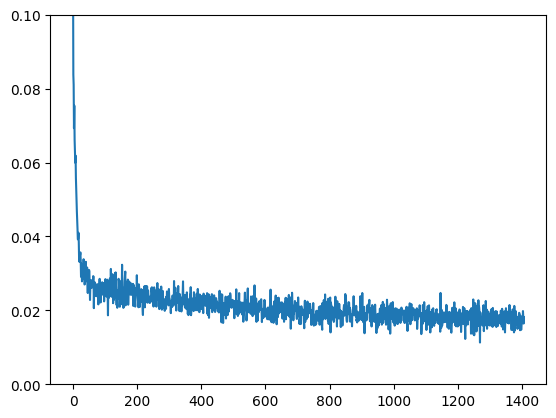

In [35]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);